In [1]:
## Kalau kerjakan di google colab, install dulu emcee dan corner
# !pip install -U emcee
# !pip install corner

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import emcee
import corner
from scipy import stats

In [3]:
def plot_chain(labels, sampler, figsize=(10, 4), alpha=0.5, thin=1):
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=figsize, sharex=True)
    axes = np.atleast_1d(axes)
    samples = sampler.get_chain(thin=thin)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
    fig.show()

In [4]:
def sampled(theta, M):
    L, _ = theta.shape
    indices = np.random.choice(L, size=M, replace=True)
    samples = theta[indices, :]
    return samples

# 1. Sampel acak

Tinjau sebuah galaksi yang memiliki distribusi kerapatan jumlah berikut dalam koordinat
silinder:
\begin{align}
    n(r, z) = n_0 \textrm{ sech}\left(\frac{r}{r_0}\right) \exp\left(-\frac{|z|}{z_0}\right)
\end{align}

maka bisa ditebak bahwa (rapat) probabilitas menemukan bintang pada $z$ dan $r$ adalah
\begin{align}
    P(r, z) \propto n(r, z)
\end{align}

Misalkan galaksi tersebut memiliki $n_0 = 1$ $\textrm{pc}^{-3}$, $r_0 = 10$ kpc, dan $z_0 = 1$ kpc.

In [183]:
n_0 = 1.0
r_0 = 10_000
z_0 = 1000

Ambil sampel acak dari distribusi ini dengan menggunakan metode MCMC sebanyak
100 000 sampel. Buat plot 3D dan plot 2D untuk proyeksi bidang XY, XZ, dan YZ dari sampel yang dihasilkan.

In [184]:
def log_prob(theta):
    x = theta[0]
    y = theta[1]
    z = theta[2]
    r = np.sqrt(x**2 + y**2)

    return -1*np.log(np.cosh(r/r_0)) - np.abs(z)/z_0

In [185]:
ndim = 3
nwalkers = 16

x_0_0 = stats.uniform.rvs(size=nwalkers, loc=-10_000, scale=20_000)
y_0_0 = stats.uniform.rvs(size=nwalkers, loc=-10_000, scale=20_000)
z_0_0 = stats.uniform.rvs(size=nwalkers, loc=-100, scale=200)

p0 = np.array([x_0_0, y_0_0, z_0_0]).T
p0

array([[ 9.77590547e+03, -8.13457441e+03, -9.93125069e+01],
       [ 6.84991818e+03,  3.79693826e+02, -4.31703641e+01],
       [ 5.06778132e+03, -4.53998835e+03, -8.25263701e+01],
       [-8.76032309e+03,  4.03571178e+03,  1.45847289e+01],
       [ 9.72505706e+03,  1.71539482e+03,  6.56214925e+00],
       [ 2.87517979e+03, -5.77804654e+03,  3.45083924e+01],
       [ 9.68317876e+03,  6.59388851e+03, -7.82341568e+01],
       [ 3.81077671e+03,  9.56580161e+03,  8.86174974e+01],
       [ 3.10369049e+03,  1.44592624e+03, -6.68948080e+01],
       [ 6.65309937e+03, -7.70951922e+03,  5.55654251e+01],
       [-9.84426093e+03, -8.21805946e+03, -2.18572775e+01],
       [-4.77009867e+03,  6.90101923e+02,  9.78357949e+01],
       [ 7.94060690e+03,  9.72021761e+03, -2.72856513e+01],
       [ 4.14666054e+03,  7.54466481e+03, -9.69395750e+01],
       [ 8.47304816e+03, -4.00790634e+02, -1.51372181e+01],
       [ 2.55684595e+03, -6.95563998e+03,  3.35244054e+01]])

In [186]:
for p0_i in p0:
  print(log_prob(p0_i))


-0.7535869430438766
-0.26206780561077264
-0.29807163875637255
-0.42161468230955473
-0.4308701990258898
-0.229739915291464
-0.6482971908274507
-0.5451940064850943
-0.12440201810567353
-0.503379268782397
-0.6851986557474373
-0.20974953259547657
-0.6673860724413412
-0.42914956607854476
-0.3385690092459914
-0.28614213546896783


In [187]:
nsteps = 1000
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob
)

state_0 = sampler.run_mcmc(p0, nsteps, progress=True);

100%|██████████| 1000/1000 [00:00<00:00, 1845.72it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


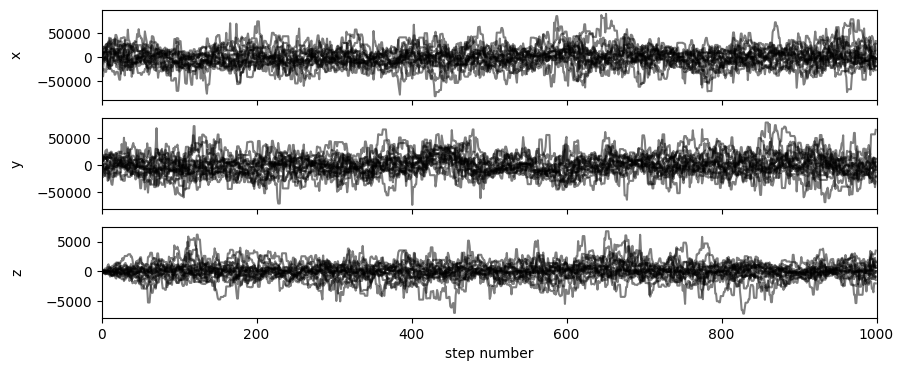

In [188]:
plot_chain(["x", "y", "z"], sampler)

In [189]:
sampler.reset()
state = sampler.run_mcmc(state_0, 100_000, progress=True);

100%|██████████| 100000/100000 [01:01<00:00, 1622.55it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


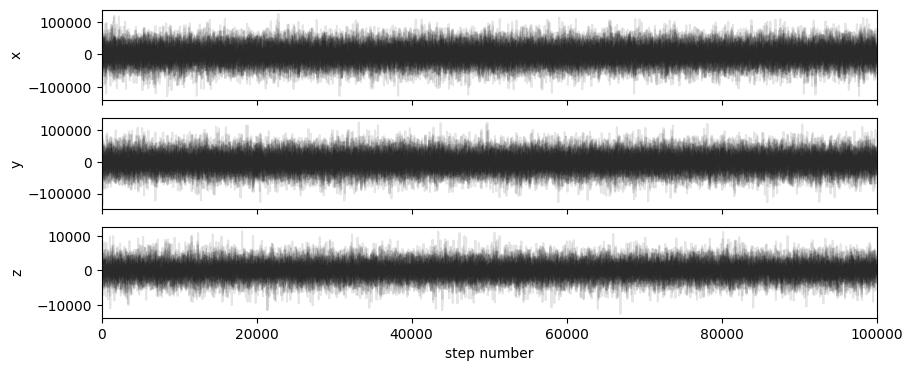

In [190]:
plot_chain(["x", "y", "z"], sampler, alpha=0.1)

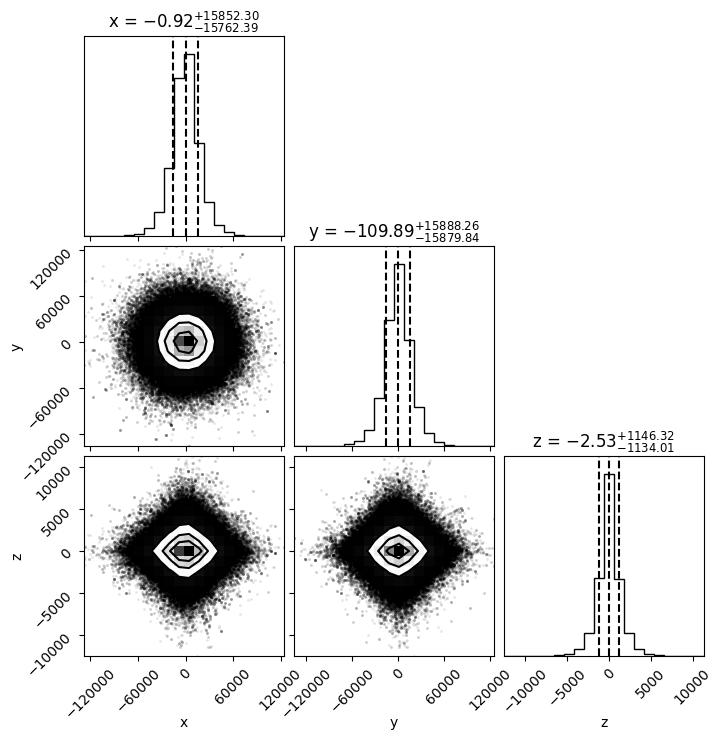

In [191]:
# corner plot
samples = sampler.get_chain(flat=True)
fig = corner.corner(
    samples, labels=["x", "y", "z"], 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [192]:
# np.save("result/bintang.npy", samples)

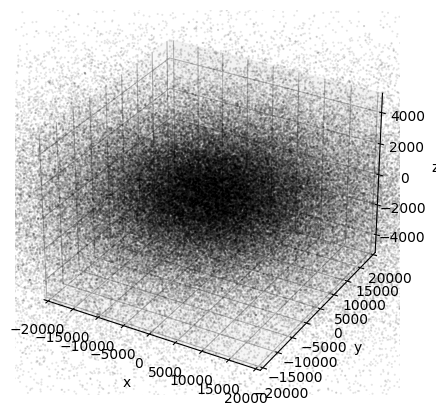

In [196]:
# plot 3D distribution
x = samples[::10, 0]
y = samples[::10, 1]
z = samples[::10, 2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='.', s=1, alpha=0.1, c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-20_000, 20_000)
ax.set_ylim(-20_000, 20_000)
ax.set_zlim(-5000, 5000)
plt.show()


# 2. Fit Bintang Variabel

Diberikan data magnitudo dan waktu pengamatan dari sebuah bintang variabel.

In [197]:
t = np.loadtxt('data/DTVir.txt', usecols=0) # waktu dalam hari
m = np.loadtxt('data/DTVir.txt', usecols=1) # magnitudo
merr = np.repeat(0.01, len(m)) # error magnitudo

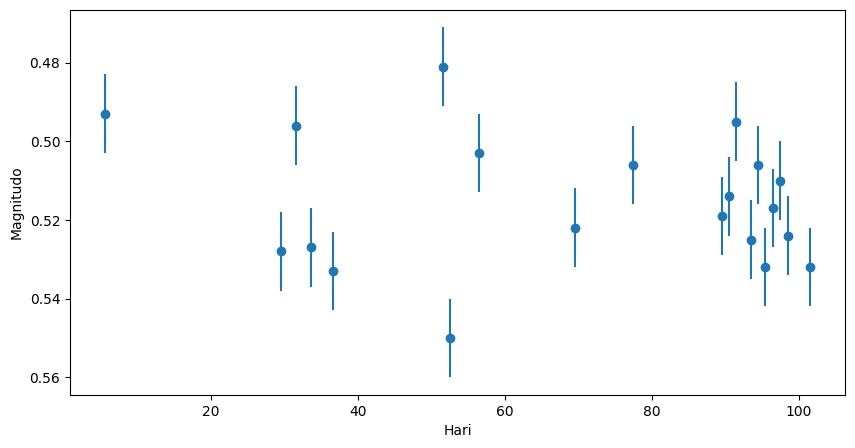

In [198]:
plt.figure(figsize=(10,5))
plt.errorbar(t, m, yerr=merr, fmt='o')
plt.xlabel('Hari')
plt.ylabel('Magnitudo')
plt.gca().invert_yaxis()
plt.show()

Modelkan variabilitas magnitudo sebagai fungsi sinusoidal berikut:
\begin{align}
    m(t) = A \sin\left(\frac{2\pi}{P} t +\phi \right) + m_0
\end{align}

Tentukan nilai parameter $A$, $P$, $\phi$, dan $m_0$ dengan melakukan fit data.
Tentukan pula ketidakpastian dari masing-masing parameter.

In [199]:
np.max(m) - np.min(m)

0.06900000000000006

In [200]:
np.mean(m)

0.5156499999999999

In [201]:
p_range = [2.8, 2.9]

def log_prior(theta):
    A = theta[0]
    P = theta[1]
    phi = theta[2]
    m0 = theta[3]

    log_prior_A = stats.uniform.logpdf(A, loc=0., scale=0.1)
    log_prior_P = stats.uniform.logpdf(P, loc=p_range[0], scale=p_range[1]-p_range[0])
    log_prior_phi = stats.uniform.logpdf(phi, loc=0, scale=2*np.pi)
    log_prior_m0 = stats.uniform.logpdf(m0, loc=0, scale=1)
    return log_prior_A + log_prior_P + log_prior_phi + log_prior_m0

def model(theta, t):
    A = theta[0]
    P = theta[1]
    phi = theta[2]
    m0 = theta[3]
    return A*np.sin(2*np.pi/P*t+phi) + m0

def log_likelihood(theta, data):
    t = data[0]
    m = data[1]
    merr = data[2]
    
    m_model = model(theta, t)
    log_likelihood = stats.norm.logpdf(m, loc=m_model, scale=merr)
    return np.sum(log_likelihood)

def log_prob(theta, data):
    log_p0 = log_prior(theta)
    if np.isinf(log_p0):
        return -np.inf
    return log_p0 + log_likelihood(theta, data)

In [202]:
ndim = 4
nwalkers = ndim * 4

A_0 = stats.uniform.rvs(size=nwalkers, loc=0.00, scale=0.1)
P_0 = stats.uniform.rvs(size=nwalkers, loc=p_range[0], scale=p_range[1]-p_range[0])
phi_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=2*np.pi)
m0_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=1)

p0 = np.array([A_0, P_0, phi_0, m0_0]).T
p0

array([[0.07768817, 2.82512049, 6.08601194, 0.2750483 ],
       [0.03176355, 2.88647083, 4.88408371, 0.08302626],
       [0.0295679 , 2.82873501, 5.45700429, 0.34103136],
       [0.08268133, 2.89570198, 2.43413324, 0.66291514],
       [0.062824  , 2.80222925, 4.24321566, 0.47528283],
       [0.08104273, 2.81631717, 5.12187069, 0.24676131],
       [0.07669687, 2.84021727, 6.2542746 , 0.90270554],
       [0.08818964, 2.82897334, 1.28675559, 0.38901801],
       [0.05131643, 2.8429105 , 3.97147963, 0.81623314],
       [0.01730399, 2.84230253, 4.71053243, 0.53048843],
       [0.07286681, 2.82014663, 4.33633386, 0.31264323],
       [0.02250492, 2.88415731, 4.14451437, 0.77942743],
       [0.06026799, 2.88107663, 3.26598953, 0.95798841],
       [0.09481111, 2.86780881, 5.27458137, 0.70262785],
       [0.08535589, 2.84051499, 5.43353892, 0.2472657 ],
       [0.06080981, 2.82435733, 5.30232927, 0.66244734]])

In [203]:
data = np.array([t, m, merr])
for p0_i in p0:
  print(log_prob(p0_i, data))

-6161.521013104111
-19167.797269893985
-3133.9445797529006
-2908.2104425742655
-394.49933942350367
-7930.505466788496
-15312.700737686007
-1909.145316821015
-8910.55775621313
35.45435704162463
-4641.055129813161
-6791.288113836835
-19700.539140444707
-3549.8769409654274
-7715.627100068131
-2243.540591929784


In [204]:
nsteps = 1000

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(data,)
)

state_0 = sampler.run_mcmc(p0, nsteps, progress=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:11<00:00, 83.80it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


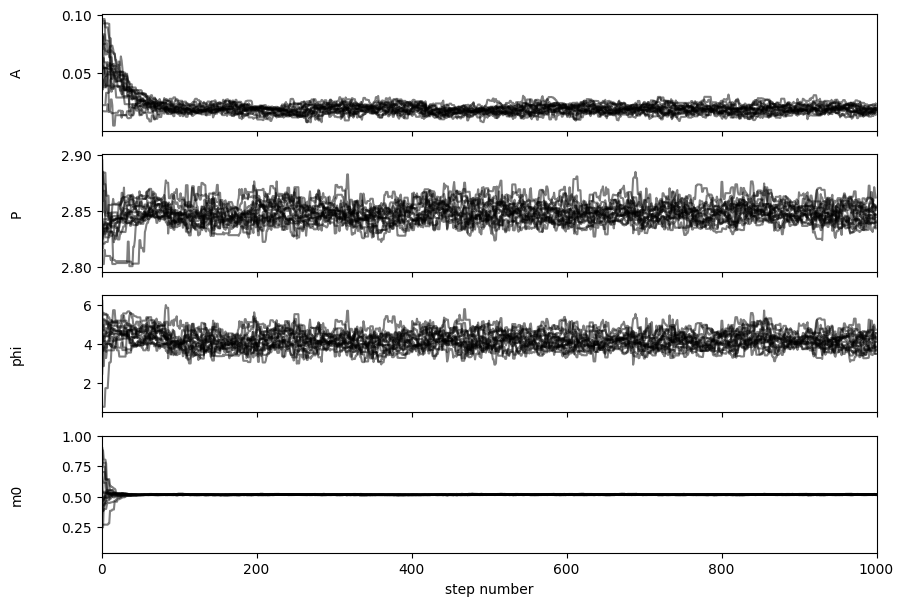

In [205]:
labels = ["A", "P", "phi", "m0"]
plot_chain(labels, sampler, figsize=(10, 7))

In [206]:
sampler.reset()
state = sampler.run_mcmc(state_0, 6_000, progress=True);

  0%|          | 7/6000 [00:00<01:28, 67.48it/s]

100%|██████████| 6000/6000 [01:31<00:00, 65.71it/s] 


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


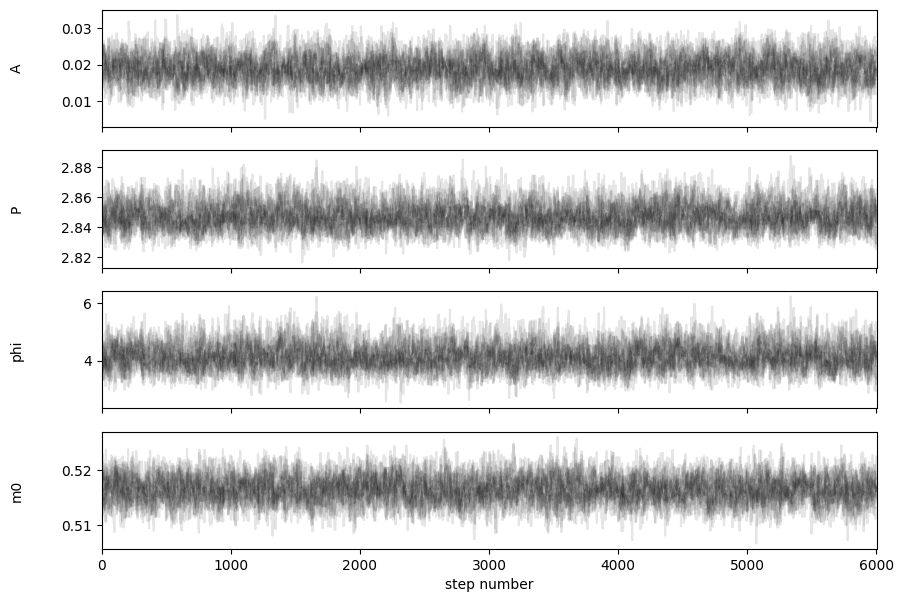

In [207]:
plot_chain(labels, sampler, figsize=(10, 7), alpha=0.1)

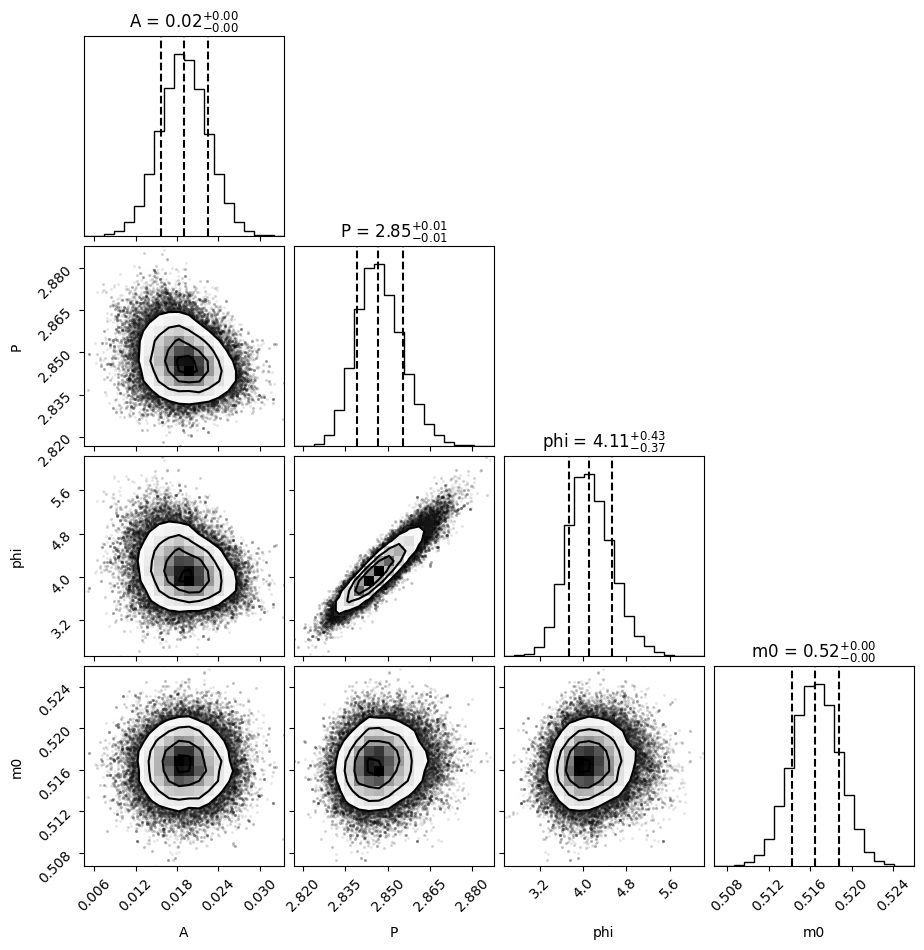

In [208]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(
    flat_samples, labels=labels, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [211]:
# np.save("result/DTVir.npy", flat_samples)

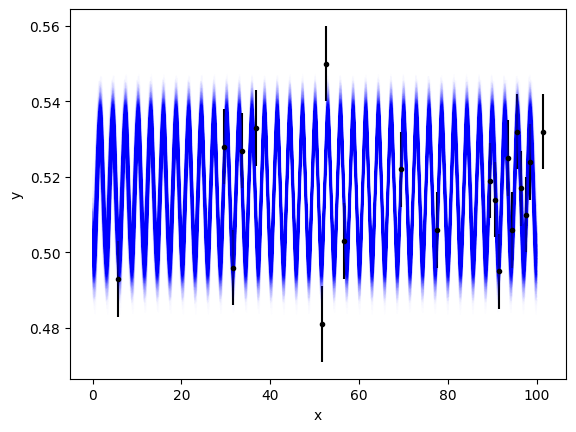

In [209]:
theta_samples = sampled(flat_samples, 1000)

plt.errorbar(t, m, yerr=merr, fmt=".k", capsize=0)
ts = np.linspace(0, 100, 500)
for theta_i in theta_samples:
  plt.plot(ts, model(theta_i, ts), "b", alpha=0.01, lw=1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

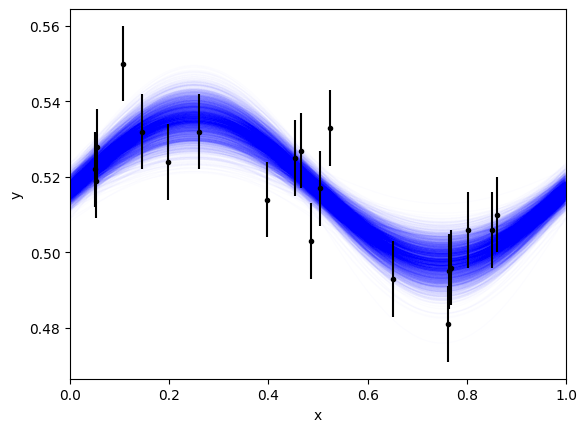

In [210]:
flat_samples = sampler.get_chain(flat=True)
theta_samples = sampled(flat_samples, 3_000)

ts = np.linspace(0, 100, 500)
for theta_i in theta_samples:
  phase = np.remainder(1/theta_i[1]*ts + theta_i[2]/(2*np.pi), 1.0)
  m_model = model(theta_i, ts)
  phase, m_model = zip(*sorted(zip(phase, m_model)))
  plt.plot(phase, m_model, "b", alpha=0.01, lw=1)
phase = np.remainder(1/2.85*t + 4.13/(2*np.pi), 1.0)
plt.errorbar(phase, m, yerr=merr, fmt=".k", capsize=0)
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 3. Fit Variasi Kecepatan Radial Bintang

Diberikan data kecepatan radial bintang yang diduga memiliki sebuah planet. Data kecepatan radial sudah dikoreksi terhadap efek kecepatan pengamat di tata surya.

In [212]:
t = np.loadtxt('data/Pr211.txt', usecols=0) # waktu dalam hari
t -= t[0]
vr = np.loadtxt('data/Pr211.txt', usecols=1) # kecepatan radial dalam km/s
vrerr = np.loadtxt('data/Pr211.txt', usecols=2) # error kecepatan radial dalam km/s

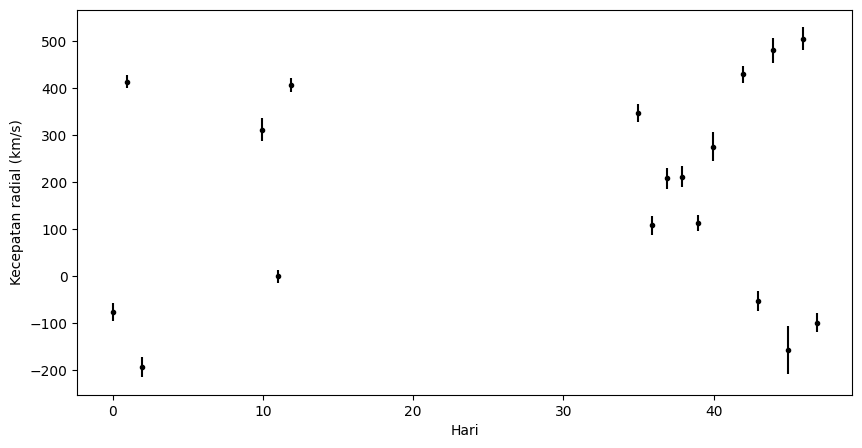

In [213]:
plt.figure(figsize=(10,5))
plt.errorbar(t, vr, yerr=vrerr, fmt='.', c='k')
plt.xlabel('Hari')
plt.ylabel('Kecepatan radial (km/s)')
plt.show()

Modelkan variasi kecepatan radial sebagai fungsi sinusoidal berikut:
\begin{align}
    v(t) = K \sin\left(\frac{2\pi}{P} t + \phi\right)+ v_0
\end{align}

Tentukan nilai parameter $K$, $P$, $\phi$, dan $v_0$ dengan melakukan fit data.
Tentukan pula ketidakpastian dari masing-masing parameter.

In [214]:
(np.max(vr) - np.min(vr))/2

348.7

In [215]:
np.mean(vr)

179.56666666666666

In [216]:
p_range = [2.1, 2.2]

def log_prior(theta):
    K = theta[0]
    P = theta[1]
    phi = theta[2]
    v0 = theta[3]

    log_prior_K = stats.uniform.logpdf(K, loc=0, scale=1000)
    log_prior_P = stats.uniform.logpdf(P, loc=p_range[0], scale=p_range[1]-p_range[0])
    log_prior_phi = stats.uniform.logpdf(phi, loc=0, scale=2*np.pi)
    log_prior_v0 = stats.uniform.logpdf(v0, loc=0, scale=400)
    return log_prior_K + log_prior_P + log_prior_phi + log_prior_v0

def model(theta, t):
    K = theta[0]
    P = theta[1]
    phi = theta[2]
    v0 = theta[3]
    return K*np.sin(2*np.pi/P*t+phi) + v0

def log_likelihood(theta, data):
    t = data[0]
    vr = data[1]
    vrerr = data[2]
    
    vr_model = model(theta, t)
    log_likelihood = stats.norm.logpdf(vr, loc=vr_model, scale=vrerr)
    return np.sum(log_likelihood)

def log_prob(theta, data):
    log_p0 = log_prior(theta)
    if np.isinf(log_p0):
        return -np.inf
    return log_p0 + log_likelihood(theta, data)

In [217]:
ndim = 4
nwalkers = ndim * 10

K_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=1000)
P_0 = stats.uniform.rvs(size=nwalkers, loc=p_range[0], scale=p_range[1]-p_range[0])
phi_0 = stats.uniform.rvs(size=nwalkers, loc=np.pi, scale=np.pi)
v0_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=400)

p0 = np.array([K_0, P_0, phi_0, v0_0]).T
p0

array([[674.11485681,   2.16789429,   5.84269461, 286.32884072],
       [833.44241038,   2.13567323,   3.43887909, 348.10752549],
       [872.68177817,   2.17851322,   3.23343871, 139.7854066 ],
       [576.26096318,   2.15402388,   5.61427014, 187.31871218],
       [446.00038489,   2.14088936,   6.07215609,  73.0956893 ],
       [343.60965659,   2.13312134,   3.68103442,  27.54953911],
       [ 97.01209811,   2.10886812,   5.13880773, 209.63393299],
       [627.22494376,   2.12482415,   5.38452322, 299.39484367],
       [ 51.40614342,   2.15629552,   4.56784255,  69.62885435],
       [ 48.69657509,   2.13760533,   6.19128341,  80.89423757],
       [700.71806565,   2.11425669,   3.77024398, 100.32697996],
       [353.24868422,   2.18371997,   6.23778338, 246.88231982],
       [710.55262945,   2.15300695,   4.50509557, 114.52122555],
       [248.87606467,   2.1529941 ,   4.84431246, 205.83353724],
       [892.9261444 ,   2.18461641,   3.88071792,  95.39676971],
       [771.68679665,   2

In [218]:
data = np.array([t, vr, vrerr])
for p0_i in p0:
  print(log_prob(p0_i, data))

-2165.2171303538303
-7300.768138183096
-9167.098145709786
-823.4179890481032
-2632.283191334579
-1503.1558390848359
-1247.4294403018757
-4688.9020528151
-1258.59595863842
-1494.1004663188044
-2324.5289353527633
-1212.4418618140733
-4823.743065250534
-377.65515182791677
-9365.923523986017
-3812.868485556253
-2506.434439999462
-609.0343572000639
-8799.114680036118
-2283.345590535121
-2607.426081138446
-2876.5670142474896
-1716.382449740546
-7166.4820082416545
-1476.1193055506074
-1239.0794242443046
-390.6667562842036
-8334.578659424658
-1684.2327434434476
-1050.1522257413712
-4992.593911673935
-766.4261364928217
-8436.170171213313
-6753.501038334365
-5892.734046873402
-11173.819850548723
-898.2837811305169
-5155.643223635356
-3865.7370710320342
-1064.4193328008676


In [219]:
nsteps = 1000

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(data,),
    moves=[
        (emcee.moves.StretchMove(), 0.6),
        (emcee.moves.DEMove(), 0.2),
        (emcee.moves.DESnookerMove(), 0.2),
    ],
)

state_0 = sampler.run_mcmc(p0, nsteps, progress=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:31<00:00, 32.12it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


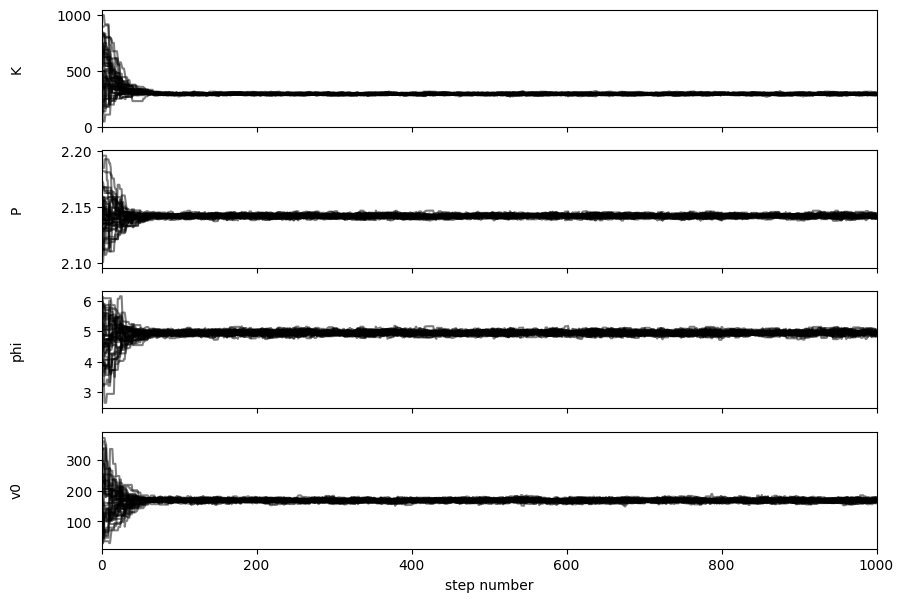

In [220]:
labels = ["K", "P", "phi", "v0"]
plot_chain(labels, sampler, figsize=(10, 7))

In [221]:
sampler.reset()
state = sampler.run_mcmc(state_0, 10_000, progress=True);
# state = sampler.run_mcmc(state, 1_000, progress=True);

100%|██████████| 10000/10000 [04:56<00:00, 33.68it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


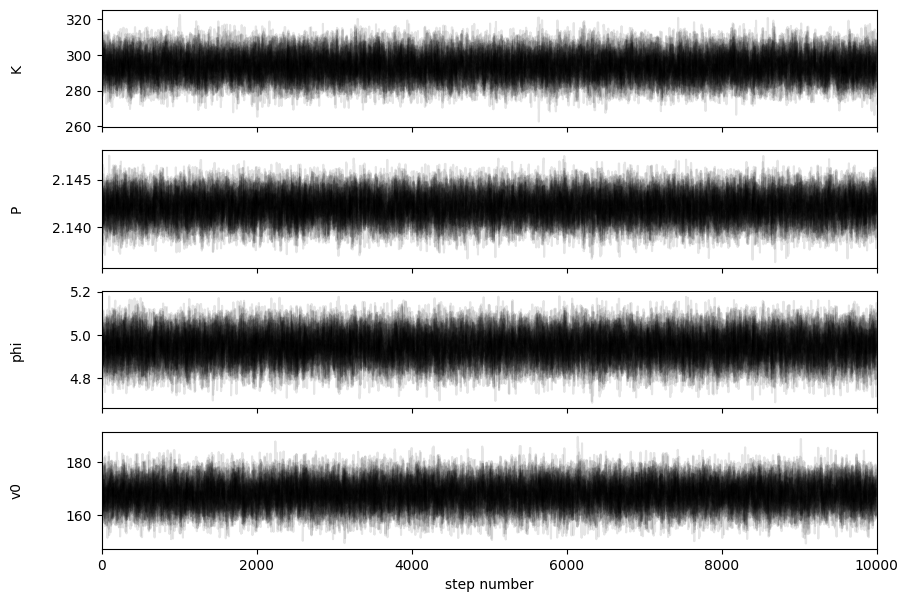

In [222]:
labels = ["K", "P", "phi", "v0"]
plot_chain(labels, sampler, figsize=(10, 7),  alpha=0.1)

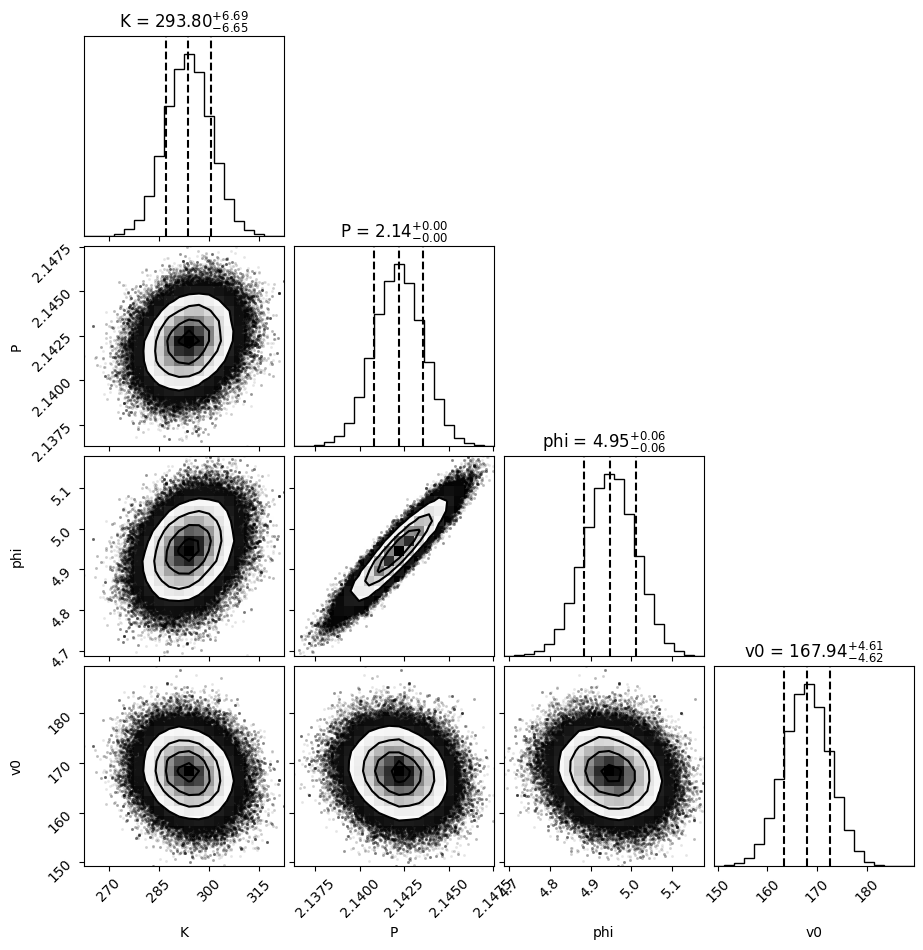

In [223]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(
    flat_samples, labels=labels, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [224]:
# np.save("result/Pr211.npy", flat_samples)

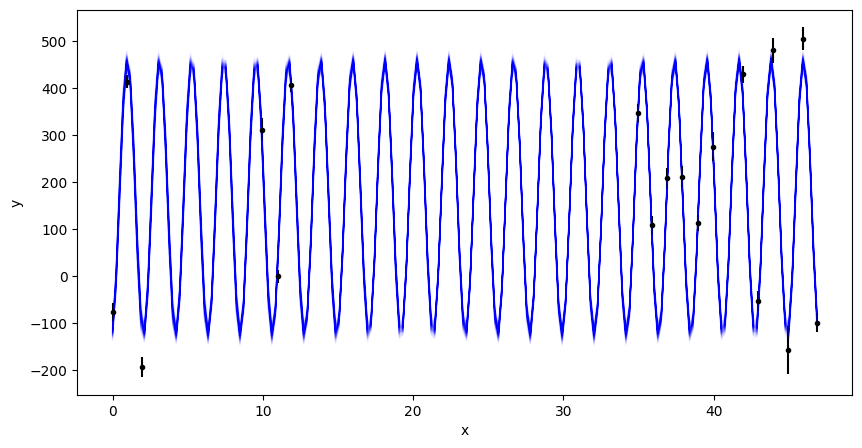

In [227]:
theta_samples = sampled(flat_samples, 300)

plt.figure(figsize=(10,5))
plt.errorbar(t, vr, yerr=vrerr, fmt=".k", capsize=0)
ts = np.linspace(0, t[-1], 200)
for theta_i in theta_samples:
    plt.plot(ts, model(theta_i, ts), "b", alpha=0.01, lw=1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

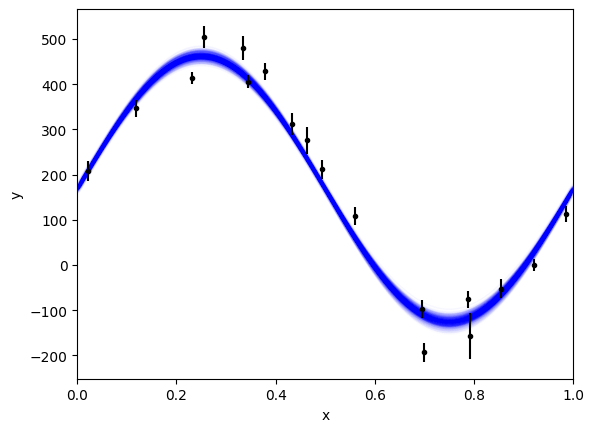

In [228]:
flat_samples = sampler.get_chain(flat=True)
theta_samples = sampled(flat_samples, 1_000)

ts = np.linspace(0, t[-1], 200)
for theta_i in theta_samples:
  phase = np.remainder(1/theta_i[1]*ts + theta_i[2]/(2*np.pi), 1.0)
  vr_model = model(theta_i, ts)
  phase, vr_model = zip(*sorted(zip(phase, vr_model)))
  plt.plot(phase, vr_model, "b", alpha=0.01, lw=1)
phase = np.remainder(1/2.14*t + 4.95/(2*np.pi), 1.0)
plt.errorbar(phase, vr, yerr=vrerr, fmt=".k", capsize=0)
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 4. Jarak ke gugus bintang

Diberikan data koordinat bintang-bintang $(\alpha, \delta)$, paralaks $\varpi\pm \sigma_{\varpi}$, dan kecepatan gerak diri $(\mu_\alpha, \mu_\delta)$ dari sebuah gugus bintang.

In [53]:
data_raw = pd.read_csv('data/gdr1set03.csv')
data_raw

,ra,dec,parallax,parallax_error,pmra,pmdec
0,55.879796,22.158187,7.418107,0.240476,19.719670,-45.481206
1,54.637015,21.284088,9.081912,0.388545,20.792591,-44.517357
2,57.588858,23.096158,7.200001,0.605311,20.868535,-46.429938
3,56.613754,24.254813,7.743384,0.322796,19.955615,-44.291813
4,56.046827,23.379132,7.998248,0.295432,22.119289,-46.981271
...,...,...,...,...,...,...
159,55.012941,27.740329,7.127912,0.256618,21.010751,-44.370785
160,56.364845,28.668498,8.444300,0.508478,22.070279,-50.010506
161,52.890208,26.265290,7.055644,0.283516,20.811421,-42.116779
162,56.496509,25.398403,7.569175,0.342092,20.288465,-45.366802


Misalkan *likelihood* dari gugus bintang ini adalah:
\begin{align*}
    P(\{\varpi\}|\{\sigma_{\varpi}\}, r_c, s_c) = \prod_{i}^{N}\int \frac{1}{\sqrt{2\pi}\sigma_{\varpi,i}}\exp\left[-\frac{\left(\varpi_i-1/r_i\right)^2}{2\sigma_{\varpi,i}^2}\right]
    \frac{1}{\sqrt{2\pi}s_c}\exp\left[-\frac{\left(r_i-r_c\right)^2}{2s_c^2}\right]\mathrm{d}r_i
\end{align*}

Dengan posterior sebagai berikut:
\begin{align*}
    P(r_c, s_c|\{\varpi\}, \{\sigma_{\varpi}\}) \propto P(\{\varpi\}|\{\sigma_{\varpi}\}, r_c, s_c) P_0(r_c)P_0(s_c)
\end{align*}

Dengan $\varpi$ adalah paralaks dan $\sigma_{\varpi}$ adalah ketidakpastian paralaks dalam satuan milidetik busur, serta $r,r_c,s_c$ dalam satuan $\textrm{kpc}$.

dan $P_0(r_c)$ adalah prior jarak gugus bintang dan $P_0(s_c)$ adalah prior ukuran gugus.

In [141]:
from scipy import integrate

def integrand(r, parallax, sigma_parallax, r_c, s_c):
    return stats.norm.pdf(1000/r, loc=parallax, scale=sigma_parallax)*stats.norm.pdf(r, loc=r_c, scale=s_c)

def log_prior(theta):
    r_c = theta[0]
    s_c = theta[1]

    log_prior_r_c = stats.uniform.logpdf(r_c, loc=0, scale=200)
    log_prior_s_c = stats.uniform.logpdf(s_c, loc=0, scale=30)
    return log_prior_r_c + log_prior_s_c

def log_likelihood(theta, data):
    r_c = theta[0]
    s_c = theta[1]
    
    parallax = data[0]
    sigma_parallax = data[1]
    rc = np.repeat(r_c, len(parallax))
    sc = np.repeat(s_c, len(parallax))

    prob = integrate.quad_vec(integrand, a=np.max([0, r_c-5*s_c]), b=r_c+5*s_c, args=(parallax, sigma_parallax, rc, sc))[0]
    log_value = np.log(prob)
    return log_value.sum()

def log_prob(theta, data):
    log_p0 = log_prior(theta)
    if np.isinf(log_p0):
        return -np.inf
    return log_p0 + log_likelihood(theta, data)


In [147]:
ndim = 2
nwalkers = ndim * 10

r_c_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=200)
s_c_0 = stats.uniform.rvs(size=nwalkers, loc=0, scale=30)

p0 = np.array([r_c_0, s_c_0]).T
p0

array([[108.90943817,  24.96259636],
       [ 54.54311004,   8.44556496],
       [165.42206237,   9.53099507],
       [197.38197969,   5.6992691 ],
       [ 86.45994963,  23.03804249],
       [190.86398626,  14.74215646],
       [ 42.03031392,   2.16245516],
       [165.98867186,  29.84301535],
       [ 97.09189376,   5.811098  ],
       [101.01126819,  17.5566056 ],
       [101.30251901,   1.80793534],
       [105.24502673,   3.78184425],
       [129.15924389,  20.11836196],
       [154.93517274,  18.3928501 ],
       [167.64353802,  17.17441308],
       [ 38.73429927,  15.65351816],
       [173.13040926,  24.89911273],
       [ 48.51059868,  15.32513612],
       [ 84.2703841 ,   3.98151457],
       [196.86878406,  21.15131011]])

In [150]:
# supress RuntimeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [154]:
data = np.array([data_raw['parallax'].values, data_raw['parallax_error'].values])
for i, p0_i in enumerate(p0):
  v = log_likelihood(p0_i, data)
  print(i, v)
    

0 -350.4265585536184
1 -10250.478280831616
2 -905.1896904036776
3 -4260.060344442105
4 -614.135499018127
5 -1279.0249241699603
6 -1279.0249241699603
7 -346.8996113873993
8 -2190.3787242358558
9 -529.0172807589645
10 -4196.522650592882
11 -2081.589682880389
12 -249.49102514767839
13 -310.77683135867767
14 -475.9189941855197
15 -3892.915074759064
16 -419.70151394291406
17 -2870.3529291326295
18 -6658.194092421337
19 -870.1607299866358


In [153]:
# p0[6] = p0[5]

In [155]:
# nsteps = 10

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_prob, args=(data,),
# )

# state_0 = sampler.run_mcmc(p0, nsteps, progress=True);

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


In [157]:
from multiprocessing import Pool
nsteps = 100

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(data,), pool=pool)
    state_0 = sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


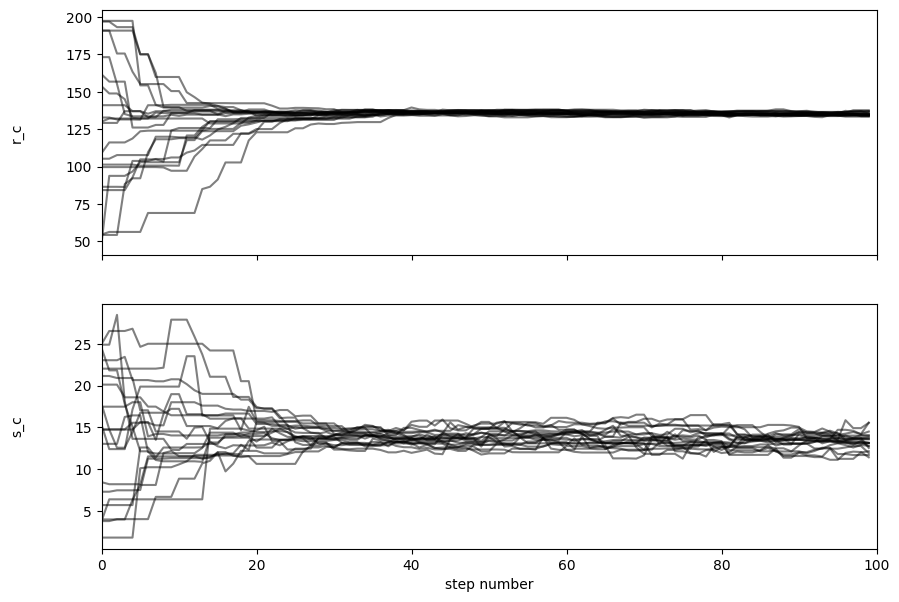

In [158]:
labels = ["r_c", "s_c"]
plot_chain(labels, sampler, figsize=(10, 7))

In [175]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(data,), pool=pool)
    state = sampler.run_mcmc(state_0, 6000, progress=True)

100%|██████████| 6000/6000 [55:15<00:00,  1.81it/s]  


/tmp/ipykernel_38949/1435349088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


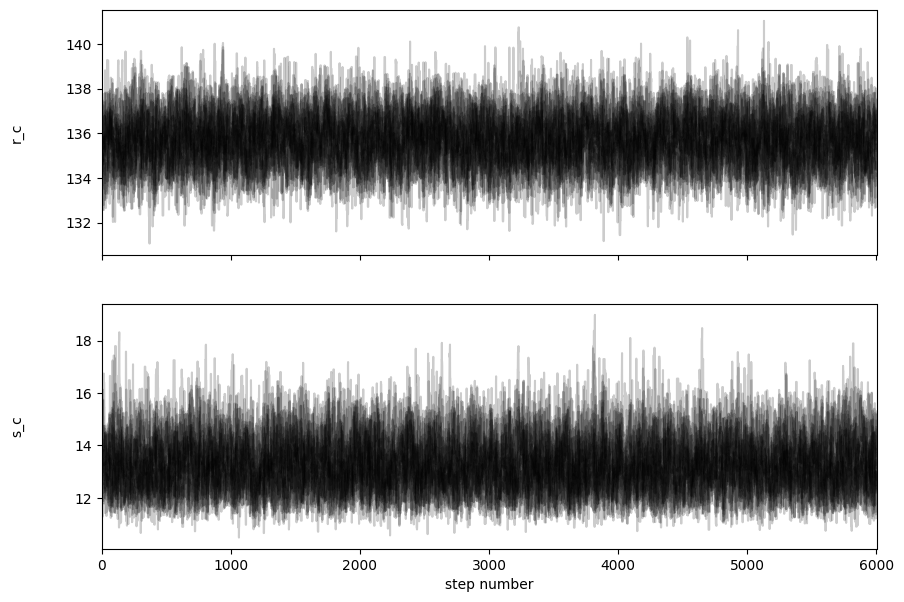

In [182]:
labels = ["r_c", "s_c"]
plot_chain(labels, sampler, figsize=(10, 7), alpha=0.2)

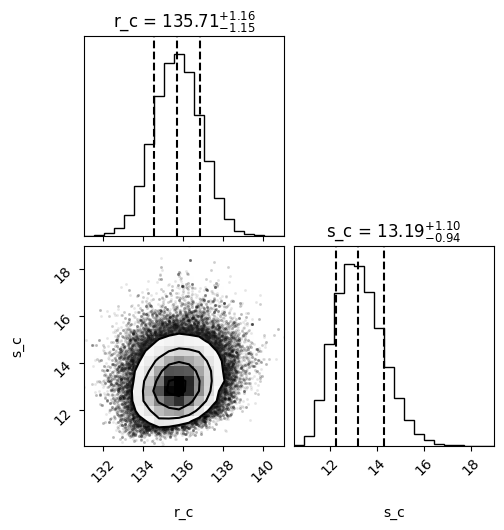

In [177]:
flat_samples = sampler.get_chain(flat=True)
fig = corner.corner(
    flat_samples, labels=labels, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)

In [178]:
# np.save('result/gugus.npy', flat_samples)

In [179]:
rc = flat_samples[:, 0]
sc = flat_samples[:, 1]

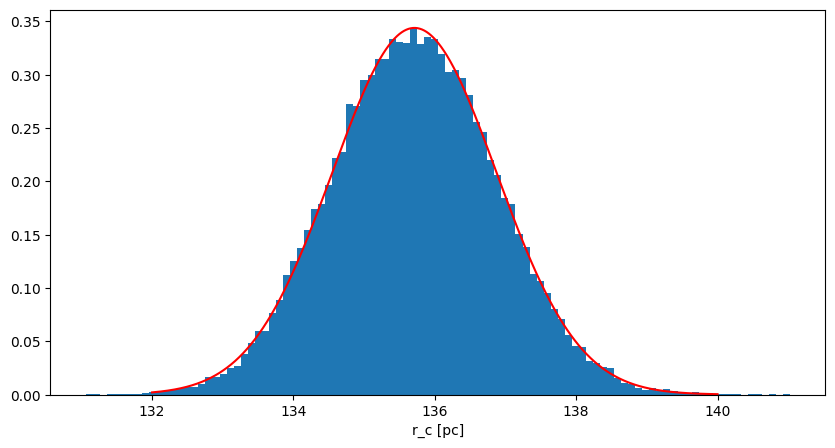

In [180]:
rc_fit = stats.norm.fit(rc)
rc_x = np.linspace(132, 140, 1000)

plt.figure(figsize=(10,5))
plt.hist(rc, bins=100, density=True)
plt.plot(rc_x, stats.norm.pdf(rc_x, *rc_fit), c='r')
plt.xlabel('r_c [pc]')
plt.show()

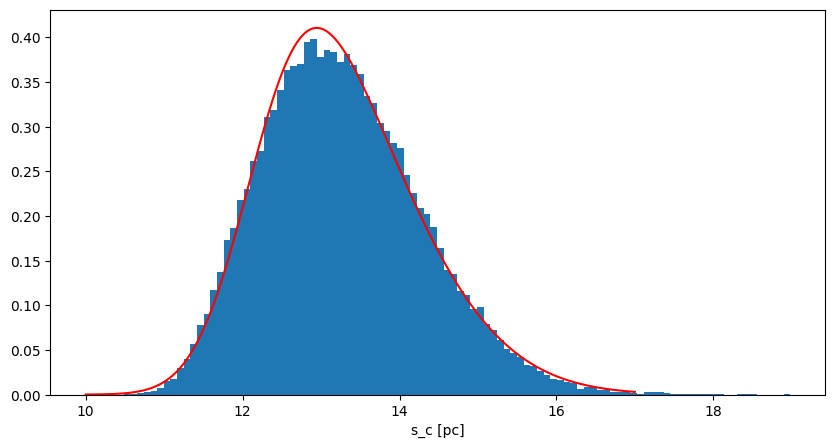

In [181]:
sc_fit = stats.skewnorm.fit(sc)
sc_x = np.linspace(10, 17, 1000)

plt.figure(figsize=(10,5))
plt.hist(sc, bins=100, density=True)
plt.plot(sc_x, stats.skewnorm.pdf(sc_x, *sc_fit), c='r')
plt.xlabel('s_c [pc]')
plt.show()